In [5]:
#Import the necessary packages

from astropy.table import Table
from matplotlib import pyplot as plt
%matplotlib inline
import os
import numpy as np
from astropy.io.ascii import masked
from astropy.io import ascii
import glob
from astropy.io import fits
import wget
import matplotlib.image as mpimg
from astropy.wcs import WCS
from scipy.stats import scoreatpercentile
from astropy.visualization import simple_norm
from reproject import reproject_interp
import sys
from IPython.display import clear_output
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats
from photutils.aperture import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.wcs import WCS
import glob
import os
from scipy.stats import scoreatpercentile
import astropy.units as u
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

mycolors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [6]:
#Set the home path

os.environ['HOME'] ='C:/Users/USER/Documents/GitHub'
homedir = os.getenv("HOME")
tabledir = homedir+'/Virgo/tables'
plotdir = homedir+'/Virgo/plots'
datadir = homedir+'/HTML-building/galaxy'

In [7]:
def imdisplay(image, v1perc=10, v2perc=95):
    '''
    display an image 
    OPTIONAL KEYWORD PARAMETERS
    v1perc: one end of the colormap assigned to the v1perc percent lowest flux 
    v2perc: the other end of the colormap assigned to the v2perc percent highest flux    
    '''
    # make sure image is an np array
    nimage = np.array(image)
    # determine the pixel values at the 10th and 95th percentile
    v1 = scoreatpercentile(nimage,v1perc)
    v2 = scoreatpercentile(nimage,v2perc)
    # display using imshow
    #
    # you can play with alternate cmaps in the function below, such as "viridis" or "gray"
    # The 'gray_r' color map reverses the color-scale so that dark display pixels are the brightest in the image
    #
    # vmin and vmax set the min and max pixel values that
    # will be mapped to the extremes of the colormap
    plt.imshow(nimage,cmap='gray',vmin=v1,vmax=v2)
    bah = plt.colorbar(fraction=.08)
    bah.remove()
def add_stars(xstars,ystars,radius=20,color='r',ax=None):
    ''' this will add circles at the location of xstars,ystars '''
    if ax is None:
        ax = plt.gca()
    allcircles=[]
    #The zip function takes iterables (e.g. lists or arrays) and groups them into tuples that contain 
    #matched pairs of each input, e.g [(x,y)]
    for x,y in zip(xstars,ystars):
        c = plt.Circle((x,y),radius,color=color,fill=False)
        #allcircles.append(c)
        ax.add_artist(c)
def find_files(destination_folder, partial_name):
    matching_files = []

    for root, dirs, files in os.walk(destination_folder):
        for file in files:
            if partial_name.lower() in file.lower():
                matching_files.append(os.path.join(root, file))

    return matching_files 

done


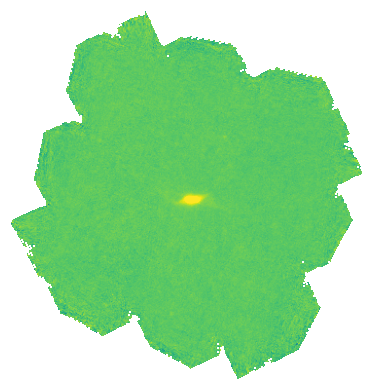

In [9]:
csv_file = homedir+'/HTML-building/Herschelstuff.csv'
galaxy = Table.read(csv_file)
for i in range(len(galaxy)):
    galaxy_name = str(galaxy['name'][i])
    path =  datadir+'/pipeline/'+galaxy_name
    VFID = str(galaxy['vfid_01'][i])
    if os.path.exists(path):
        destination_folder = path+'\\HPPUNIMAPB'
        partial_name = 'hpacs_25HPPUNIMAPB'
        found_files = find_files(destination_folder, partial_name)
        if found_files:
            found_file = found_files[0]
            data, header = fits.getdata(found_file, header=True)
            v1 = scoreatpercentile(data,0.01)
            v2 = scoreatpercentile(data,99.9)
            norm_im = simple_norm(data, 'asinh', max_percent=99.9, min_cut=v1, max_cut=v2)
            # Continue with the rest of your code for processing the data
            plt.clf()
            plt.imshow(data, origin='lower', norm=norm_im)
            plt.axis('off')
            plt.subplots_adjust(wspace=0, hspace=0)
            plt.savefig(datadir+'/png/'+VFID+'-'+galaxy_name+'blue.png', dpi=150)
        destination_folder = path+'\\HPPUNIMAPG'
        partial_name = 'hpacs_25HPPUNIMAPB'
        found_files = find_files(destination_folder, partial_name)
        if found_files:
            found_file = found_files[0]
            data, header = fits.getdata(found_file, header=True)
            v1 = scoreatpercentile(data,0.01)
            v2 = scoreatpercentile(data,99.9)
            norm_im = simple_norm(data, 'asinh', max_percent=99.9, min_cut=v1, max_cut=v2)
            # Continue with the rest of your code for processing the data
            plt.clf()
            plt.imshow(data, origin='lower', norm=norm_im)
            plt.axis('off')
            plt.subplots_adjust(wspace=0, hspace=0)
            plt.savefig(datadir+'/png/'+VFID+'-'+galaxy_name+'green.png', dpi=150)
        destination_folder = path+'\\HPPUNIMAPR'
        partial_name = 'hpacs_25HPPUNIMAPR'
        found_files = find_files(destination_folder, partial_name)
        if found_files:
            found_file = found_files[0]
            data, header = fits.getdata(found_file, header=True)
            v1 = scoreatpercentile(data,0.01)
            v2 = scoreatpercentile(data,99.9)
            norm_im = simple_norm(data, 'asinh', max_percent=99.9, min_cut=v1, max_cut=v2)
            # Continue with the rest of your code for processing the data
            plt.clf()
            plt.imshow(data, origin='lower', norm=norm_im)
            plt.axis('off')
            plt.subplots_adjust(wspace=0, hspace=0)
            plt.savefig(datadir+'/png/'+VFID+'-'+galaxy_name+'red.png', dpi=150)
    else:
        print(f"Galaxy not found: {VFID}")
        print(galaxy_name)
print('done')

In [10]:
csv_file = homedir+'/HTML-building/Herschelstuff.csv'
galaxy = Table.read(csv_file)
pixscale=1   #standard
pscale = 0
xsize = 0
for i in range(len(galaxy)):
    galaxy_name = str(galaxy['name'][i])
    path =  datadir+'/pipeline/'+galaxy_name
    destination_folder = path+'/HPPUNIMAPR/'
    partial_name = 'hpacs_25HPPUNIMAPR'
    found_files = find_files(destination_folder, partial_name)
    VFID = str(galaxy['vfid_01'][i])
    filename_LS = datadir+'/png/'+VFID+'-'+galaxy_name+'-LS.jpg'
    RA = galaxy['ra_01'][i]
    DEC = galaxy['dec_01'][i]
    if os.path.exists(path):
        if found_files:
            found_file = found_files[0]
            image, head = fits.getdata(found_file, header=True)
            wcs_info = WCS(head) 
            pscale=np.abs(float(head['CDELT1']))   #grab transformation matrix of Herschel image
            xsize=np.abs(int(head['NAXIS1']))   #grab length of Herschel image
            xsize_arcsec=pscale*3600*xsize   #length convert to arcseconds
            imsize=int(xsize_arcsec/pixscale)   #convert length to an integer
            imsize=str(imsize)   #convert integer length to a...string       
            image_url = f'https://www.legacysurvey.org/viewer/cutout.jpg?ra={RA}&dec={DEC}&layer=ls-dr9&size={imsize}&pixscale={1}'
            if os.path.exists(filename_LS):
                os.remove(filename_LS)
                imageLS = wget.download(image_url,out=filename_LS)
            else:
                imageLS = wget.download(image_url,out=filename_LS)
    else:
        print(f"Galaxy not found: {VFID}-{galaxy_name}")
print('done')

100% [............................................................................] 341984 / 341984done
